# Machine Learning Prototype

The goal of this notebook is to create a binary classifier that is able to distinguish benign from malicious network traffic based on the [CIC-IDS-2018 dataset](https://www.unb.ca/cic/datasets/ids-2018.html).  
The classifier will use a subset of the features generated by the [CICFlowMeter](https://github.com/ISCX/CICFlowMeter) for each observation.  

In order to find the most suitable classifier the following machine learning algorithms will be evaluated:
* Logistic Regression
* Random Forest
* Gradient Boosting

The preprocessed dataset from CIC-IDS-2018 can be found at [Google Drive](https://drive.google.com/open?id=1HrTPh0YRSZ4T9DLa_c47lubheKUcPl0r).

In [3]:
dataset_base_path = r'/home/glados/Development/Projects/ids-2018/processed'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import shap
import scikitplot as skplt
import eli5
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
from catboost import CatBoostClassifier
from catboost import Pool
from eli5.sklearn import PermutationImportance
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from collections import defaultdict
from scipy.stats import ks_2samp
from scipy.stats import describe
from imblearn.over_sampling import SMOTENC
from collections import Counter
from IPython.display import display

%matplotlib inline

In [4]:
types = {
    'dst_port': 'uint32',
    'protocol': 'uint8',
    'timestamp': 'object',
    'flow_duration': 'int64',
    'tot_fwd_pkts': 'uint32',
    'tot_bwd_pkts': 'uint32',
    'totlen_fwd_pkts': 'uint32',
    'totlen_bwd_pkts': 'uint32',
    'fwd_pkt_len_max': 'uint16',
    'fwd_pkt_len_min': 'uint16',
    'fwd_pkt_len_mean': 'float32',
    'fwd_pkt_len_std': 'float32',
    'bwd_pkt_len_max': 'uint16',
    'bwd_pkt_len_min': 'uint16',
    'bwd_pkt_len_mean': 'float32',
    'bwd_pkt_len_std': 'float32',
    'flow_byts_s': 'float64',
    'flow_pkts_s': 'float64',
    'flow_iat_mean': 'float32',
    'flow_iat_std': 'float32',
    'flow_iat_max': 'int64',
    'flow_iat_min': 'int64',
    'fwd_iat_tot': 'int64',
    'fwd_iat_mean': 'float32',
    'fwd_iat_std': 'float32',
    'fwd_iat_max': 'int64',
    'fwd_iat_min': 'int64',
    'bwd_iat_tot': 'uint32',
    'bwd_iat_mean': 'float32',
    'bwd_iat_std': 'float32',
    'bwd_iat_max': 'uint32',
    'bwd_iat_min': 'uint32',
    'fwd_psh_flags': 'uint8',
    'bwd_psh_flags': 'uint8',
    'fwd_urg_flags': 'uint8',
    'bwd_urg_flags': 'uint8',
    'fwd_header_len': 'uint32',
    'bwd_header_len': 'uint32',
    'fwd_pkts_s': 'float32',
    'bwd_pkts_s': 'float32',
    'pkt_len_min': 'uint16',
    'pkt_len_max': 'uint16',
    'pkt_len_mean': 'float32',
    'pkt_len_std': 'float32',
    'pkt_len_var': 'float32',
    'fin_flag_cnt': 'uint8',
    'syn_flag_cnt': 'uint8',
    'rst_flag_cnt': 'uint8',
    'psh_flag_cnt': 'uint8',
    'ack_flag_cnt': 'uint8',
    'urg_flag_cnt': 'uint8',
    'cwe_flag_count': 'uint8',
    'ece_flag_cnt': 'uint8',
    'down_up_ratio': 'uint16',
    'pkt_size_avg': 'float32',
    'fwd_seg_size_avg': 'float32',
    'bwd_seg_size_avg': 'float32',
    'fwd_byts_b_avg': 'uint8',
    'fwd_pkts_b_avg': 'uint8',
    'fwd_blk_rate_avg': 'uint8',
    'bwd_byts_b_avg': 'uint8',
    'bwd_pkts_b_avg': 'uint8',
    'bwd_blk_rate_avg': 'uint8',
    'subflow_fwd_pkts': 'uint32',
    'subflow_fwd_byts': 'uint32',
    'subflow_bwd_pkts': 'uint32',
    'subflow_bwd_byts': 'uint32',
    'init_fwd_win_byts': 'int32',
    'init_bwd_win_byts': 'int32',
    'fwd_act_data_pkts': 'uint32',
    'fwd_seg_size_min': 'uint8',
    'active_mean': 'float32',
    'active_std': 'float32',
    'active_max': 'uint32',
    'active_min': 'uint32',
    'idle_mean': 'float32',
    'idle_std': 'float32',
    'idle_max': 'uint64',
    'idle_min': 'uint64',
    'label': 'category'
}

def replace_infinity_with_mean(df):
    inf_columns = [c for c in df.columns if df[df[c] == np.inf][c].count() > 0]
    for col in inf_columns:
        df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df


def replace_negative_values_with_mean(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.values
    
    columns = [c for c in numeric_cols if df[df[c] < 0][c].count() > 0]
    for col in columns:
        mask = df[col] < 0
        df.loc[mask, col] = np.nan
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df


def load_dataset(files, dtypes, cols=None):
    df = pd.concat((pd.read_csv(f, dtype=dtypes, usecols=cols) for f in files))
    
    df = replace_infinity_with_mean(df)
    df = replace_negative_values_with_mean(df)
        
    df['label_cat'] = df.label.astype('category').cat.codes
    df['label_is_attack'] = (df.label != 'Benign').astype('int')
    return df

## 1. Dataset Preparation

In the first step the dataset is loaded into a Pandas dataframe, additional columns `label_cat` (numeric category of the label) and `label_is_attack` (binary target identifier specifying benign and malicious network traffic) are added and the dataframe is split into the predictor variables `X` and the target variables `y`.

In [4]:
csv_files = glob.glob(os.path.join(dataset_base_path, '*.csv'))

df = load_dataset(csv_files, types)
X = df.drop(columns=['label', 'label_cat', 'label_is_attack'])
y = df[['label_is_attack', 'label_cat', 'label']]

## 2. Feature Engineering

### 2.1. Low Amount of Variance

As a first step in feature engineering all features with zero amount of variation are removed as those features will not have any influence on the prediction of the target variable. In order to find those features descriptive statistics are created via Pandas. All features having a standard deviation of `0` are selected and will be dropped subsequently.

In [5]:
stats = X.describe()
std = stats.loc['std']
features_no_variance = std[std == 0.0].index
pd.Series(features_no_variance).sort_values()

7    bwd_blk_rate_avg
5      bwd_byts_b_avg
6      bwd_pkts_b_avg
0       bwd_psh_flags
1       bwd_urg_flags
4    fwd_blk_rate_avg
2      fwd_byts_b_avg
3      fwd_pkts_b_avg
dtype: object

In [6]:
X = X.drop(columns=features_no_variance)

### 2.2. Undesired Features

The predictions of a classifier should be agnostic to the features `timestamp` and `dst_port` in order to recognize attacks indifferent of time and the destination port they are executed against. To this end both of the features are removed from the dataset.

In [7]:
X = X.drop(columns=['timestamp', 'dst_port'])

### 2.3. Multicolliniar Features

Features having a high correlation amongst each other are removed in the next step. Those features won't bring any additional predictability but may introduce noise.  
In order to identify those features hierarchical clustering on the Spearman rank-order correlations is performed.
After picking a threshold a single feature of each cluster is preserved in the dataset.

The following figures show a heatmap visualzing the correlation between different pairs of features and a dendogram illustrating the clustering of the features.

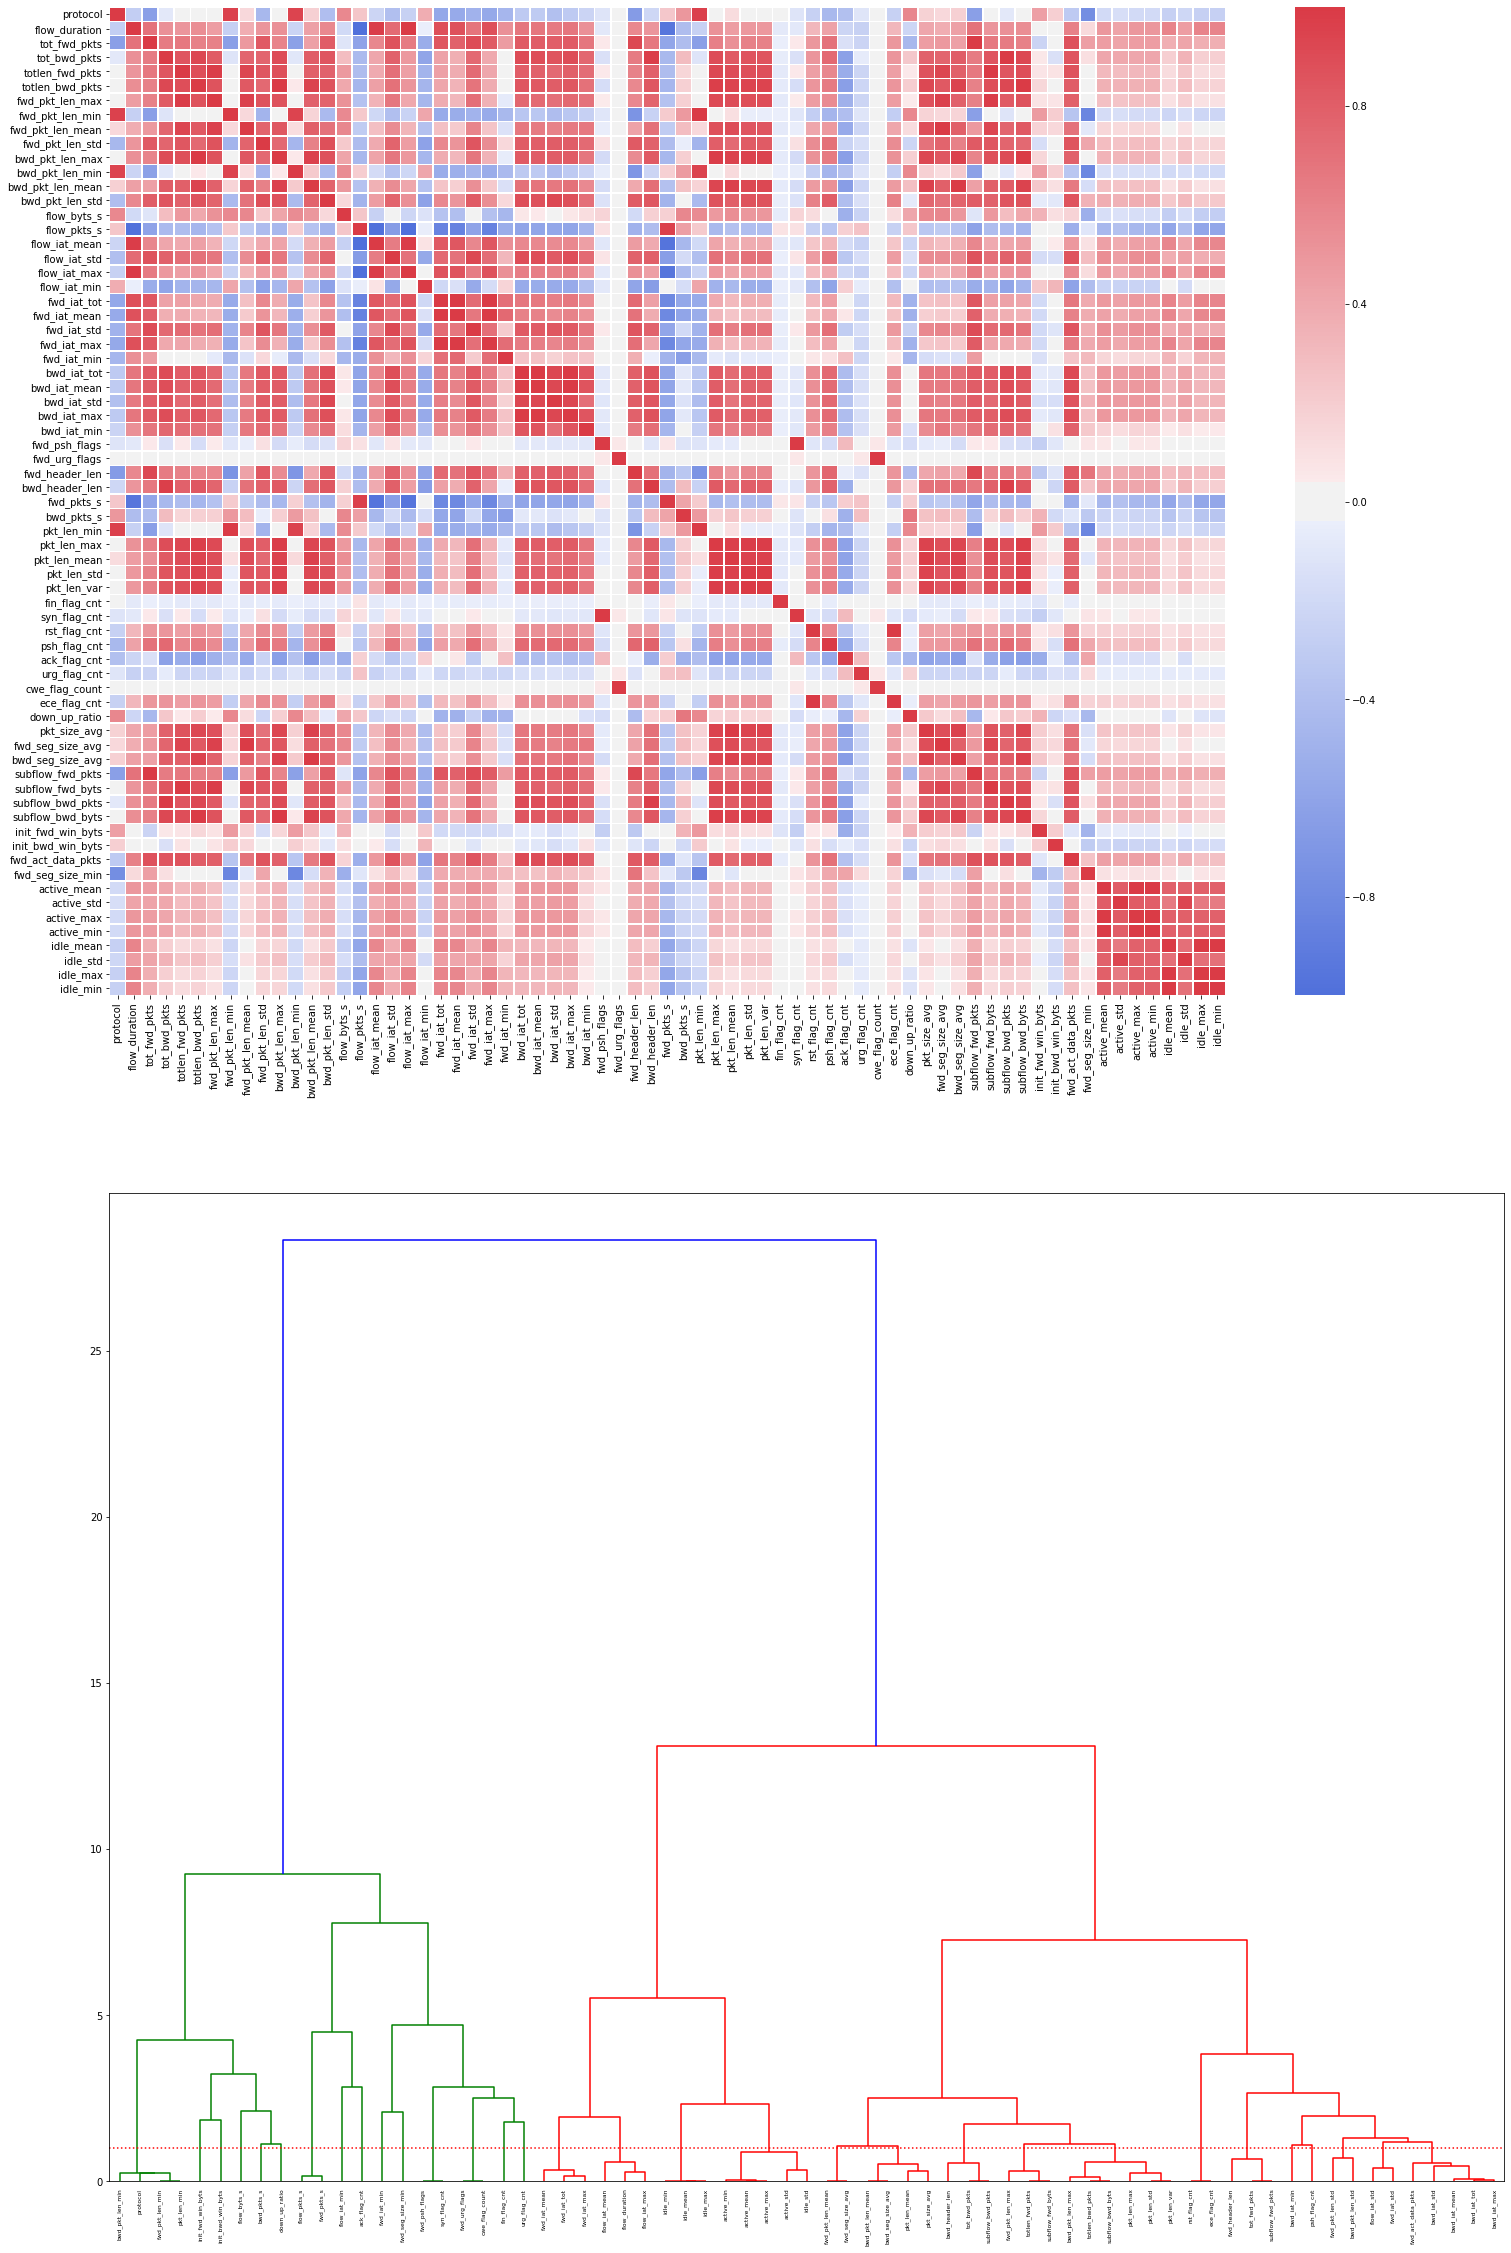

In [8]:
cluster_threshold = 1

corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 40))

sns.heatmap(corr, xticklabels=X.columns, yticklabels=X.columns, linewidths=.5, cmap=sns.diverging_palette(620, 10, as_cmap=True), ax=ax1)

dendro = hierarchy.dendrogram(corr_linkage, labels=X.columns, ax=ax2, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro['ivl']))
ax2.plot([0, 1000], [cluster_threshold, cluster_threshold], ':r')
plt.show()

The heatmap demonstrates that the dataset has a fair amount of features with high correlation amongst each other. In order to remove redundant features the cluster distance threshold of `1` is used to pick features from their respective clusters.

In [9]:
cluster_ids = hierarchy.fcluster(corr_linkage, cluster_threshold, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)

for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

selected_features = X.columns[selected_features].tolist()

print('Selected features:')
pd.Series(selected_features)

Selected features:


0              protocol
1         flow_duration
2          tot_fwd_pkts
3          tot_bwd_pkts
4       totlen_fwd_pkts
5       totlen_bwd_pkts
6      fwd_pkt_len_mean
7       fwd_pkt_len_std
8      bwd_pkt_len_mean
9           flow_byts_s
10          flow_pkts_s
11         flow_iat_std
12         flow_iat_min
13          fwd_iat_tot
14          fwd_iat_min
15          bwd_iat_tot
16          bwd_iat_min
17        fwd_psh_flags
18        fwd_urg_flags
19           bwd_pkts_s
20         fin_flag_cnt
21         rst_flag_cnt
22         psh_flag_cnt
23         ack_flag_cnt
24         urg_flag_cnt
25        down_up_ratio
26    init_fwd_win_byts
27    init_bwd_win_byts
28     fwd_seg_size_min
29          active_mean
30            idle_mean
dtype: object

In [6]:
X = X[selected_features]
print(f"Remaining amount of features: {len(X.columns)}")

Remaining amount of features: 31


The following figure shows the correlation heatmap after the removal of highly correlated features.

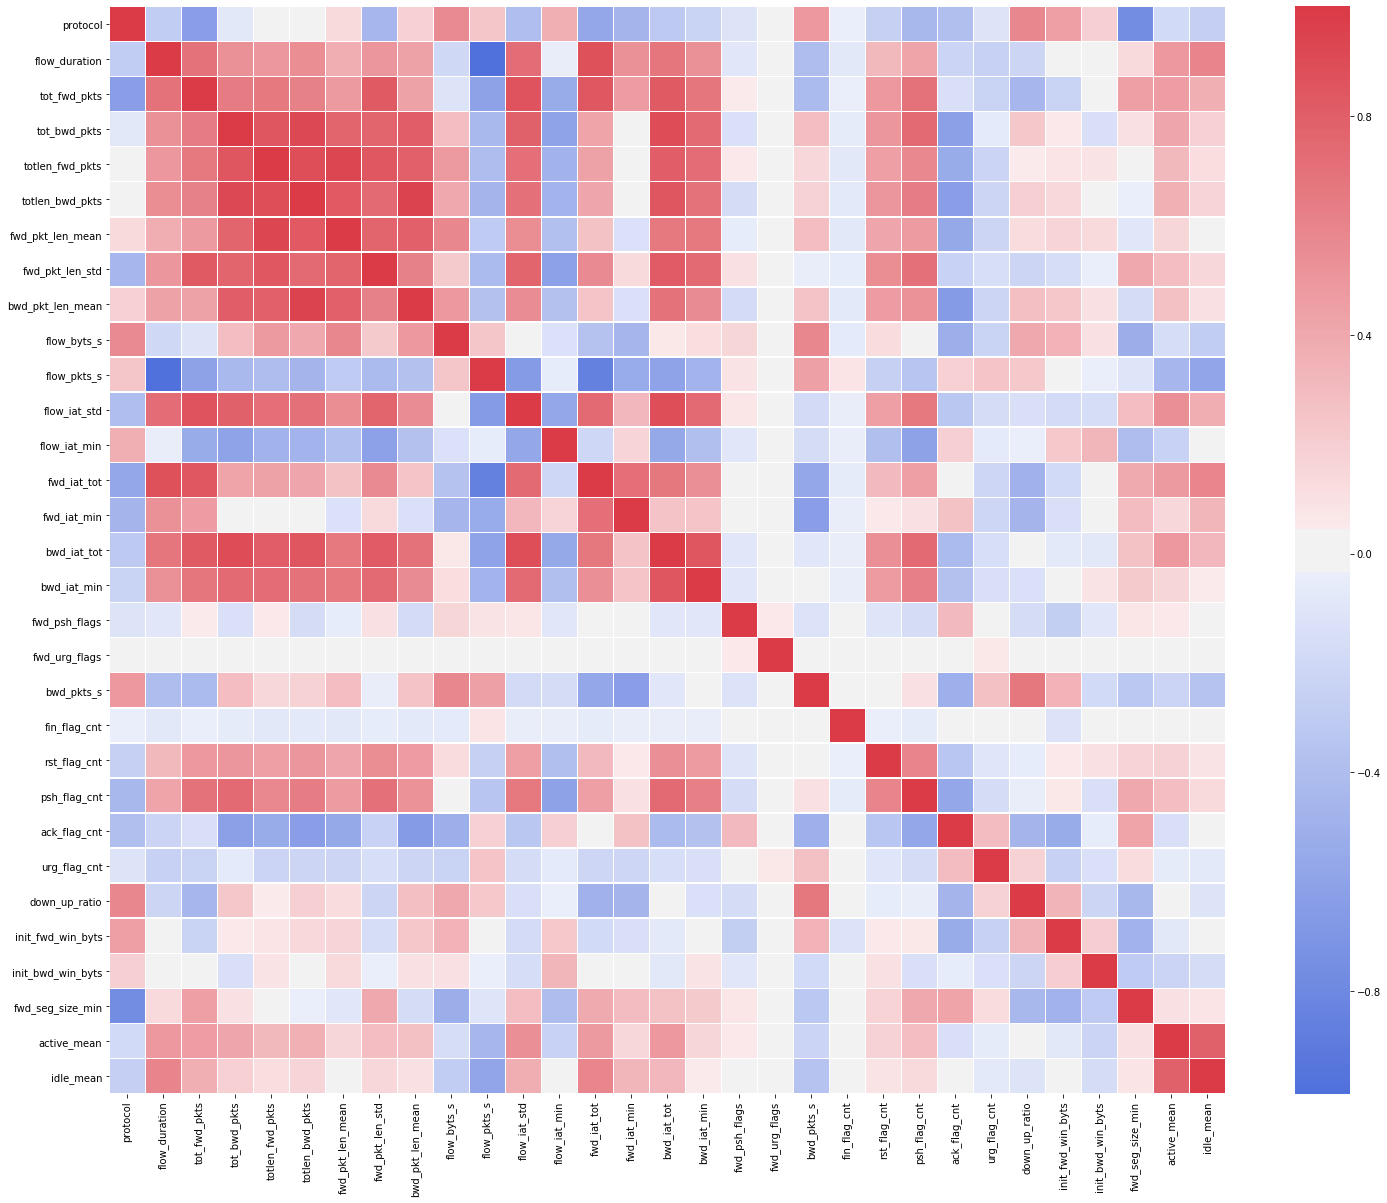

In [11]:
corr_updated = spearmanr(X).correlation
plt.figure(figsize=(25, 20))
sns.heatmap(corr_updated, xticklabels=X.columns, yticklabels=X.columns, linewidths=.5, cmap=sns.diverging_palette(620, 10, as_cmap=True))

## 3. Model Training Preparation

### 3.1. Train / Test split

In order to train and evaluate different models a train/evaluation/test split is created with the ratios of `0.8/0.1/0.1`.  
The split is stratified using the attack category in order to guarantee that all attacks are represented in the training and test set based on their occurences in the dataset.  
To use algorithms expecting categorical values being one-hot-encoded, copies of the training and test data are created (`X_train_oh`, `X_test_oh`) with the feature `protocol` being one-hot-encoded.

In [20]:
def print_report(ds_type, cls, X_vals, y_true, y_predict, plot_pr=False, plot_roc=False):
    print(f"Classification Report ({ds_type}):")
    print(classification_report(y_true, y_predict))
    print(f"Avg Precision Score: {average_precision_score(y_true, y_predict, average='weighted')}")
    
    if plot_roc:
        print(f"ROC AUC Score: {roc_auc_score(y_true, y_predict)}")
        skplt.metrics.plot_roc(y_true, cls.predict_proba(X_vals))
        plt.show()
        
    if plot_pr:
        
        skplt.metrics.plot_precision_recall(y_true, cls.predict_proba(X_vals))
        plt.show()
        
    print('\n')

In [8]:
X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.2, stratify=y.label_cat)
X_eval, X_test, y_eval, y_test = train_test_split(X_hold, y_hold, test_size=0.5, stratify=y_hold.label_cat)

X_train_oh = pd.get_dummies(X_train, columns=['protocol'])
X_eval_oh = pd.get_dummies(X_eval, columns=['protocol'])
X_test_oh = pd.get_dummies(X_test, columns=['protocol'])

In [14]:
y.label.value_counts()

Benign                      13484708
DDOS attack-HOIC              686012
DDoS attacks-LOIC-HTTP        576191
DoS attacks-Hulk              461912
Bot                           286191
FTP-BruteForce                193360
SSH-Bruteforce                187589
Infilteration                 161934
DoS attacks-SlowHTTPTest      139890
DoS attacks-GoldenEye          41508
DoS attacks-Slowloris          10990
DDOS attack-LOIC-UDP            1730
Brute Force -Web                 611
Brute Force -XSS                 230
SQL Injection                     87
Name: label, dtype: int64

In [15]:
y_train.label.value_counts()

Benign                      10787766
DDOS attack-HOIC              548809
DDoS attacks-LOIC-HTTP        460953
DoS attacks-Hulk              369530
Bot                           228953
FTP-BruteForce                154688
SSH-Bruteforce                150071
Infilteration                 129547
DoS attacks-SlowHTTPTest      111912
DoS attacks-GoldenEye          33206
DoS attacks-Slowloris           8792
DDOS attack-LOIC-UDP            1384
Brute Force -Web                 489
Brute Force -XSS                 184
SQL Injection                     70
Name: label, dtype: int64

In [16]:
y_eval.label.value_counts()

Benign                      1348471
DDOS attack-HOIC              68601
DDoS attacks-LOIC-HTTP        57619
DoS attacks-Hulk              46191
Bot                           28619
FTP-BruteForce                19336
SSH-Bruteforce                18759
Infilteration                 16193
DoS attacks-SlowHTTPTest      13989
DoS attacks-GoldenEye          4151
DoS attacks-Slowloris          1099
DDOS attack-LOIC-UDP            173
Brute Force -Web                 61
Brute Force -XSS                 23
SQL Injection                     9
Name: label, dtype: int64

In [17]:
y_test.label.value_counts()

Benign                      1348471
DDOS attack-HOIC              68602
DDoS attacks-LOIC-HTTP        57619
DoS attacks-Hulk              46191
Bot                           28619
FTP-BruteForce                19336
SSH-Bruteforce                18759
Infilteration                 16194
DoS attacks-SlowHTTPTest      13989
DoS attacks-GoldenEye          4151
DoS attacks-Slowloris          1099
DDOS attack-LOIC-UDP            173
Brute Force -Web                 61
Brute Force -XSS                 23
SQL Injection                     8
Name: label, dtype: int64

### 3.2 Metrics

In [18]:
percentage_benign = len(y_train.label_is_attack[y_train.label_is_attack == 0]) / len(y_train.label_is_attack)

print('Class occurences:')
print(y_train.label_is_attack.value_counts())
print('Percentage of benign samples: %.4f' % percentage_benign)

Class occurences:
0    10787766
1     2198588
Name: label_is_attack, dtype: int64
Percentage of benign samples: 0.8307


The distribution of classes shows that the dataset is highly imbalanced with class `0 - Benign` contributing to `~83%` of all the samples.  
For this reason the metric `accuracy` is not suitable to measure the performance of a classifier based on this dataset as the `accuracy` of a dummy classifier reporting the class `0 - Benign` would already be `0.83` as shown in section `4.1`.

To evaluate the performance of a classifier two metrics will be used:
* `Recall (weighted avg)` will be used as the primary metric as the goal of the classifier should be detect as many attacks as possible. This is the metric that classifiers will be optimized for.
* `Precision (weighted avg)` will be used as a secondary classifier as the the number of false-positives should be kept to a minimum. This metric should be have a value over the threshold of `0.95` to have a maximum of `5%` false-positives.

The `Avg Precision Score` score will also be calculated for each classifier.

## 4. Classifiers

### 4.1 Baseline Classifier

To establish a baseline for all classifiers a `DummyClassifier` is created choosing the class with the most frequent occurences to make predictions. In this case all samples are classified as `0 - Benign` as this is the majority class of the dataset.  
This classifier shows that `~83%` of all training examples are of class `0 - Benign`.

In [19]:
cls_dummy = DummyClassifier('most_frequent')
cls_dummy.fit(X_train, y_train.label_is_attack)

print_report('Train', cls_dummy, X_train, y_train.label_is_attack, cls_dummy.predict(X_train))
print_report('Eval', cls_dummy, X_eval, y_eval.label_is_attack, cls_dummy.predict(X_eval))

Classification Report (Train):


/home/glados/anaconda3/envs/ml-ids/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.83      1.00      0.91  10787766
           1       0.00      0.00      0.00   2198588

    accuracy                           0.83  12986354
   macro avg       0.42      0.50      0.45  12986354
weighted avg       0.69      0.83      0.75  12986354

Avg Precision Score: 0.16929986661383173


Classification Report (Eval):
              precision    recall  f1-score   support

           0       0.83      1.00      0.91   1348471
           1       0.00      0.00      0.00    274823

    accuracy                           0.83   1623294
   macro avg       0.42      0.50      0.45   1623294
weighted avg       0.69      0.83      0.75   1623294

Avg Precision Score: 0.16929958467166145




### 4.2 Logistic Regression

Using the Logistic Regression estimator a linear model will be fitted to the data using the [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) implementation from [scikit-learn](https://scikit-learn.org/). In order to use Logistic Regression the predictor variables are scaled via a [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).  
Using Logistic Regression a weighted recall of `0.88` and a precision of `0.87` which is better than the baseline but not sufficient for real-world usage.

In [20]:
scaler = StandardScaler()
scaler.fit(X_train_oh)

StandardScaler(copy=True, with_mean=True, with_std=True)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


max_iter reached after 1383 seconds


/home/glados/anaconda3/envs/ml-ids/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 23.0min finished


Classification Report (Train):
              precision    recall  f1-score   support

           0       0.90      0.95      0.93  10787766
           1       0.68      0.49      0.57   2198588

    accuracy                           0.88  12986354
   macro avg       0.79      0.72      0.75  12986354
weighted avg       0.87      0.88      0.87  12986354

Avg Precision Score: 0.42270786673763255


Classification Report (Eval):
              precision    recall  f1-score   support

           0       0.90      0.95      0.93   1348471
           1       0.68      0.49      0.57    274823

    accuracy                           0.88   1623294
   macro avg       0.79      0.72      0.75   1623294
weighted avg       0.86      0.88      0.87   1623294

Avg Precision Score: 0.4220228570050777


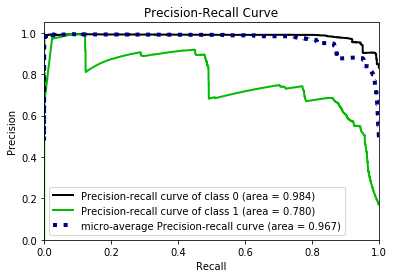

In [21]:
cls_lr = LogisticRegression(solver='saga', n_jobs=-1, verbose=2)
cls_lr.fit(scaler.transform(X_train_oh), y_train.label_is_attack)

print_report('Train', cls_lr, scaler.transform(X_train_oh), y_train.label_is_attack, cls_lr.predict(scaler.transform(X_train_oh)))
print_report('Eval', cls_lr, scaler.transform(X_eval_oh), y_eval.label_is_attack, cls_lr.predict(scaler.transform(X_eval_oh)), plot_pr=True)

### 4.3 Random Forest

The next algorithm evaluated is the [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) implementation from [scikit-learn](https://scikit-learn.org/). The default values are used to train the estimator.  
`RandomForestClassifier` performs very well with recall of `0.99` and precision of `0.99`.

/home/glados/anaconda3/envs/ml-ids/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.6min remaining:   42.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.7min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    5.9s remaining:   23.4s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    7.1s finished


Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99  10787766
           1       0.97      0.98      0.97   2198588

    accuracy                           0.99  12986354
   macro avg       0.98      0.98      0.98  12986354
weighted avg       0.99      0.99      0.99  12986354

Avg Precision Score: 0.9502138122792624




[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.7s remaining:    2.8s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    1.0s finished


Classification Report (Eval):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1348471
           1       0.96      0.95      0.96    274823

    accuracy                           0.99   1623294
   macro avg       0.98      0.97      0.97   1623294
weighted avg       0.99      0.99      0.99   1623294

Avg Precision Score: 0.9253892970122982


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.7s remaining:    2.8s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    1.1s finished


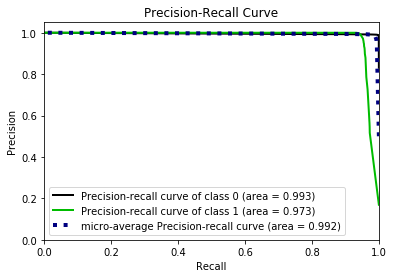

In [23]:
cls_forest = RandomForestClassifier(verbose=1, n_jobs=-1, class_weight='balanced')
cls_forest.fit(X_train_oh, y_train.label_is_attack)

print_report('Train', cls_forest, X_train_oh, y_train.label_is_attack, cls_forest.predict(X_train_oh))
print_report('Eval', cls_forest, X_eval_oh, y_eval.label_is_attack, cls_forest.predict(X_eval_oh), plot_pr=True)

### 4.4 Gradient Boosting

The last algorithm to evaluate is Gradient Boosting by facilitating the library [CatBoost](https://catboost.ai/). A grid search using cross-validation over a variation of hyper-parameters is performed in order to identify the optimal parameters. 

In [9]:
train_pool = Pool(X_train, y_train.label_is_attack, cat_features=['protocol'])
eval_pool = Pool(X_eval, y_eval.label_is_attack, cat_features=['protocol'])
test_pool = Pool(X_test, cat_features=['protocol'])

In [ ]:
minority_class_weight = len(y_train[y_train.label_is_attack == 0]) / len(y_train[y_train.label_is_attack == 1])
    
cls_cb = CatBoostClassifier(loss_function='Logloss',
                            eval_metric='Recall',                        
                            class_weights=[1, minority_class_weight],
                            task_type='GPU',
                            verbose=True)

cls_cb.fit(train_pool, eval_set=eval_pool)

Classification Report (Train):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99  10787766
           1       0.97      0.96      0.96   2198588

    accuracy                           0.99  12986354
   macro avg       0.98      0.98      0.98  12986354
weighted avg       0.99      0.99      0.99  12986354

Avg Precision Score: 0.9341507909896061


Classification Report (Eval):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1348471
           1       0.97      0.96      0.96    274823

    accuracy                           0.99   1623294
   macro avg       0.98      0.97      0.98   1623294
weighted avg       0.99      0.99      0.99   1623294

Avg Precision Score: 0.9333906081606897


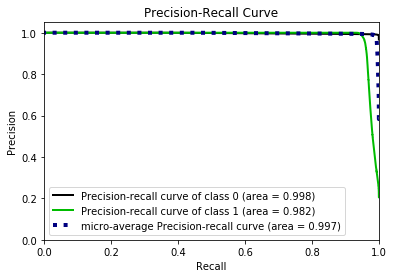

In [11]:
print_report('Train', cls_cb, train_pool, y_train.label_is_attack, cls_cb.predict(train_pool))
print_report('Eval', cls_cb, eval_pool, y_eval.label_is_attack, cls_cb.predict(eval_pool), plot_pr=True)

### 4.5 Model selection

Comparing the models the following results are obtained:

|Model|Recall|Precision|F1|Avg PR|Recall Attack|Precision Attack|
|-----|---------|------|--|------|-------------|----------------|
|Baseline|0.83|0.69|0.75|0.169|0.00|0.00|
|Logistic Regression|0.88|0.86|0.87|0.422|0.49|0.68|
|Random Forest|**0.99**|0.99|0.99|0.925|**0.95**|**0.96**|
|Gradient Boost|**0.99**|0.99|0.99|0.933|**0.96**|**0.97**|

Gradient Boost performed best of all models and will be used as the final estimator.

In [12]:
estimator = cls_cb

### 4.6 Performance on Test dataset

To predict real-world performance the final estimator is evaluated on the test dataset.

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1348471
           1       0.97      0.96      0.96    274824

    accuracy                           0.99   1623295
   macro avg       0.98      0.97      0.98   1623295
weighted avg       0.99      0.99      0.99   1623295

Avg Precision Score: 0.933930661288721


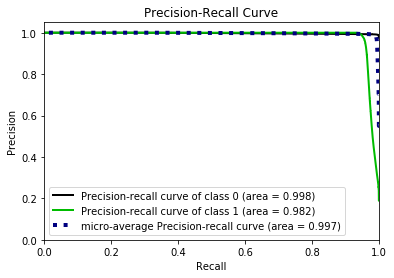

In [13]:
print_report('Test', estimator, test_pool, y_test.label_is_attack, estimator.predict(test_pool), plot_pr=True)

The final estimator shows very good performance with recall of `0.99` and precision of `0.99`.  
The following listing shows the misclassifications in the test dataset which demonstrate that attacks of type `Infiltration` are often misclassified.  
Futhermore minority classes of attacks are often misclassified. Synthetic minority oversampling may be applied to the train dataset for these classes to gain better performance.

In [54]:
def calculate_misclassifiations(y, predictions):
    classifications = y.copy()
    classifications['pred'] = predictions
    counts = classifications.label.value_counts()
    
    misclassifications = classifications[classifications.label_is_attack != classifications.pred]
    mc = pd.DataFrame(misclassifications.label.value_counts())
    mc['percentage'] = mc.apply(lambda x: x[0] / counts[x.name], axis=1)
    mc = mc.sort_values('percentage', ascending=False)
    
    print('Misclassifications:')
    display(mc)

In [55]:
calculate_misclassifiations(y_test, estimator.predict(test_pool))

Misclassifications:


,label,percentage
Infilteration,11937,0.737125
Brute Force -Web,32,0.524590
SQL Injection,3,0.375000
Brute Force -XSS,3,0.130435
DoS attacks-Slowloris,13,0.011829
Benign,8425,0.006248
Bot,35,0.001223
DDoS attacks-LOIC-HTTP,8,0.000139


## 5. Novel Data from different network environment

In order to verify that the estimator has an equally good performance as shown in the test dataset additional tests a performed on the [CIC-IDS-2017](https://www.unb.ca/cic/datasets/ids-2017.html) dataset which contains the same attack scenarios but recorded in a different network environment.

### 5.1. Test on novel data

The preprocessed dataset from CIC-IDS-2017 can be found at [Google Drive](https://drive.google.com/open?id=1Q2J_pPB0K0PHjq0YO5BPwYQwrvoZgYqo).

In [5]:
novel_base_path= r'/home/glados/Development/Projects/ids-2017/processed'

In [57]:
novel_files = glob.glob(os.path.join(novel_base_path, '*.csv'))

df_novel = load_dataset(novel_files, types, cols=selected_features + ['label'])

X_novel = df_novel.drop(columns=['label', 'label_cat', 'label_is_attack'])
y_novel = df_novel[['label_is_attack', 'label_cat', 'label']]

In [58]:
print(f"Number of test samples: {len(X_novel)}")

Number of test samples: 2830743


Classification Report (Novel):
              precision    recall  f1-score   support

           0       0.84      0.96      0.90   2273097
           1       0.63      0.26      0.36    557646

    accuracy                           0.82   2830743
   macro avg       0.73      0.61      0.63   2830743
weighted avg       0.80      0.82      0.79   2830743

Avg Precision Score: 0.307365267074596


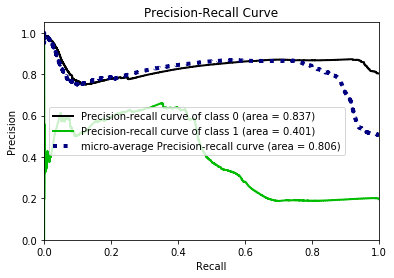

In [59]:
novel_pool = Pool(X_novel, cat_features=['protocol'])

print_report('Novel', estimator, novel_pool, y_novel.label_is_attack, estimator.predict(novel_pool), plot_pr=True)

Unfortunately the estimator has very poor performance on data recorded in a different network environment showing a recall of `0.82` and a precision of `0.80`. Moreover the estimator has only attack recall of `0.26` which is insufficient for real-world usage.  
This result suggests that data from one network environment does not generalize well to a different network environment.

In [60]:
calculate_misclassifiations(y_novel, estimator.predict(novel_pool))

Misclassifications:


,label,percentage
Bot,1966,1.000000
Infilteration,36,1.000000
Heartbleed,11,1.000000
DDOS LOIT,127927,0.999219
SSH-Bruteforce,5878,0.996778
Brute Force -XSS,638,0.978528
Brute Force -Web,1435,0.952223
SQL Injection,18,0.857143
DoS attacks-SlowHTTPTest,4670,0.849245
DoS attacks-Hulk,180659,0.781827


### 5.2. Feature importance

In order to analyse the problem the feature importances of the model are calculated. The most important features will be used to compare data from the two datasets.

In [44]:
perm = PermutationImportance(estimator, scoring='recall_weighted', n_iter=3).fit(X_test, y_test.label_is_attack)
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

Weight,Feature
0.0575 ± 0.0001,init_fwd_win_byts
0.0274 ± 0.0002,fwd_seg_size_min
0.0131 ± 0.0001,tot_fwd_pkts
0.0114 ± 0.0001,fwd_iat_tot
0.0099 ± 0.0000,totlen_fwd_pkts
0.0046 ± 0.0001,tot_bwd_pkts
0.0046 ± 0.0002,init_bwd_win_byts
0.0032 ± 0.0001,flow_duration
0.0027 ± 0.0001,bwd_pkt_len_mean
0.0026 ± 0.0000,flow_iat_min


In [46]:
features_to_analyze = ['init_fwd_win_byts', 'fwd_seg_size_min', 'tot_fwd_pkts', 'fwd_iat_tot']

### 5.3. Statistical Analysis

The following listings compare the data from both datasets for the identified features.  
The complete, benign and attack data of the two datasets are compared by plotting their distributions, calculating summary statistics and performing a [Kolmogorov-Smirnov statistic](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html).

In [47]:
def stats(vals):
    d = describe(vals)
    return pd.DataFrame.from_dict({
        'nobs': d.nobs, 
        'min': d.minmax[0], 
        'max': d.minmax[1], 
        'mean': d.mean, 
        'median': np.median(vals),
        'std': np.std(vals),
        'variance': d.variance,
        'skewness': d.skewness, 
        'kurtosis': d.kurtosis
     }, orient='index')


def print_distributions(X_1, y_1, X_2, y_2, f, label_1='1', label_2='2'):
    print(f"Distribution for field '{f}'")
    print("===================================")
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 20))
    
    X_f_1 = X_1[f]
    X_f_2 = X_2[f]
    X_attack_1 = X_f_1[y_1.label_is_attack == 1]
    X_benign_1 = X_f_1[y_1.label_is_attack == 0]
    X_attack_2 = X_f_2[y_2.label_is_attack == 1]
    X_benign_2 = X_f_2[y_2.label_is_attack == 0]

    sns.distplot(X_f_1, label=f'All {label_1}', hist=False, ax=ax1)
    sns.distplot(X_f_2, label=f'All {label_2}', hist=False, ax=ax1)

    sns.distplot(X_benign_1, label=f'Benign {label_1}', hist=False, ax=ax2)
    sns.distplot(X_benign_2, label=f'Benign {label_2}', hist=False,  ax=ax2)

    sns.distplot(X_attack_1, label=f'Attack {label_1}', hist=False, ax=ax3)
    sns.distplot(X_attack_2, label=f'Attack {label_2}', hist=False, ax=ax3)    
    plt.show()

    print('K2 All:')
    print(ks_2samp(X_f_1, X_f_2))
    print('K2 Benign:')
    print(ks_2samp(X_benign_1, X_benign_2))
    print('K2 Attack:')
    print(ks_2samp(X_attack_1, X_attack_2))

    st = pd.concat({
        f'All {label_1}': stats(X_f_1),
        f'All {label_2}': stats(X_f_2),
        f'Benign {label_1}': stats(X_benign_1),
        f'Benign {label_2}': stats(X_benign_2),
        f'Attack {label_1}': stats(X_attack_1),
        f'Attack {label_2}': stats(X_attack_2)
    }, axis=1)
    
    print()
    print(st)
    print('\n')

Distribution for field 'init_fwd_win_byts'


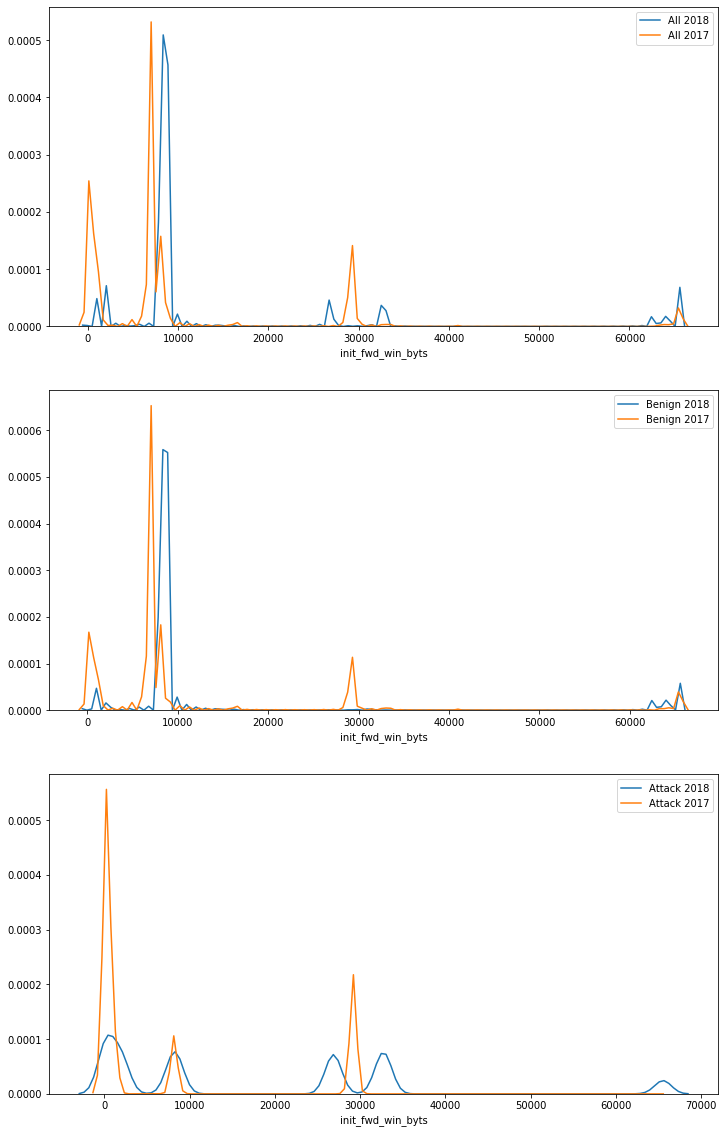

K2 All:
Ks_2sampResult(statistic=0.44235392107565924, pvalue=0.0)
K2 Benign:
Ks_2sampResult(statistic=0.47378059106970455, pvalue=0.0)
K2 Attack:
Ks_2sampResult(statistic=0.4434562553612962, pvalue=0.0)

              All 2018      All 2017   Benign 2018   Benign 2017  \
                     0             0             0             0   
nobs      1.623294e+07  2.830743e+06  1.348471e+07  2.273097e+06   
min       0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max       6.553500e+04  6.553500e+04  6.553500e+04  6.553500e+04   
mean      1.118693e+04  9.462386e+03  1.003846e+04  9.970655e+03   
median    8.192000e+03  6.989837e+03  8.192000e+03  6.989837e+03   
std       1.538657e+04  1.349816e+04  1.455744e+04  1.386692e+04   
variance  2.367467e+08  1.822004e+08  2.119191e+08  1.922915e+08   
skewness  2.622149e+00  2.564942e+00  3.179946e+00  2.730492e+00   
kurtosis  6.227754e+00  7.048015e+00  9.178910e+00  7.574957e+00   

           Attack 2018   Attack 2017  
        

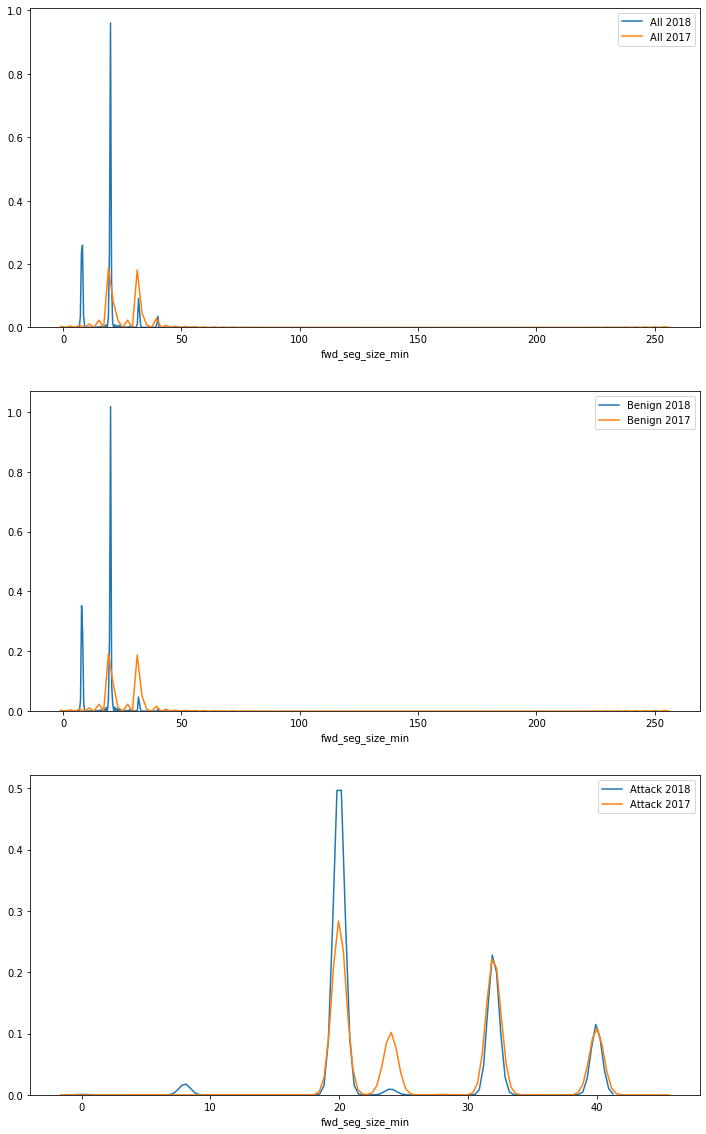

K2 All:
Ks_2sampResult(statistic=0.4055406906104775, pvalue=0.0)
K2 Benign:
Ks_2sampResult(statistic=0.4385982621560479, pvalue=0.0)
K2 Attack:
Ks_2sampResult(statistic=0.22266068679150747, pvalue=0.0)

              All 2018      All 2017   Benign 2018   Benign 2017  \
                     0             0             0             0   
nobs      1.623294e+07  2.830743e+06  1.348471e+07  2.273097e+06   
min       0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max       5.600000e+01  2.550000e+02  5.600000e+01  2.550000e+02   
mean      1.799267e+01  2.611845e+01  1.650157e+01  2.579871e+01   
median    2.000000e+01  2.400000e+01  2.000000e+01  2.000000e+01   
std       7.693845e+00  6.625706e+00  6.757963e+00  6.402757e+00   
variance  5.919525e+01  4.389999e+01  4.567006e+01  4.099532e+01   
skewness  2.556202e-01  8.693634e-01 -1.903372e-01  9.961939e-01   
kurtosis  5.638952e-01  1.627596e+01 -6.595508e-02  2.375664e+01   

           Attack 2018    Attack 2017  
        

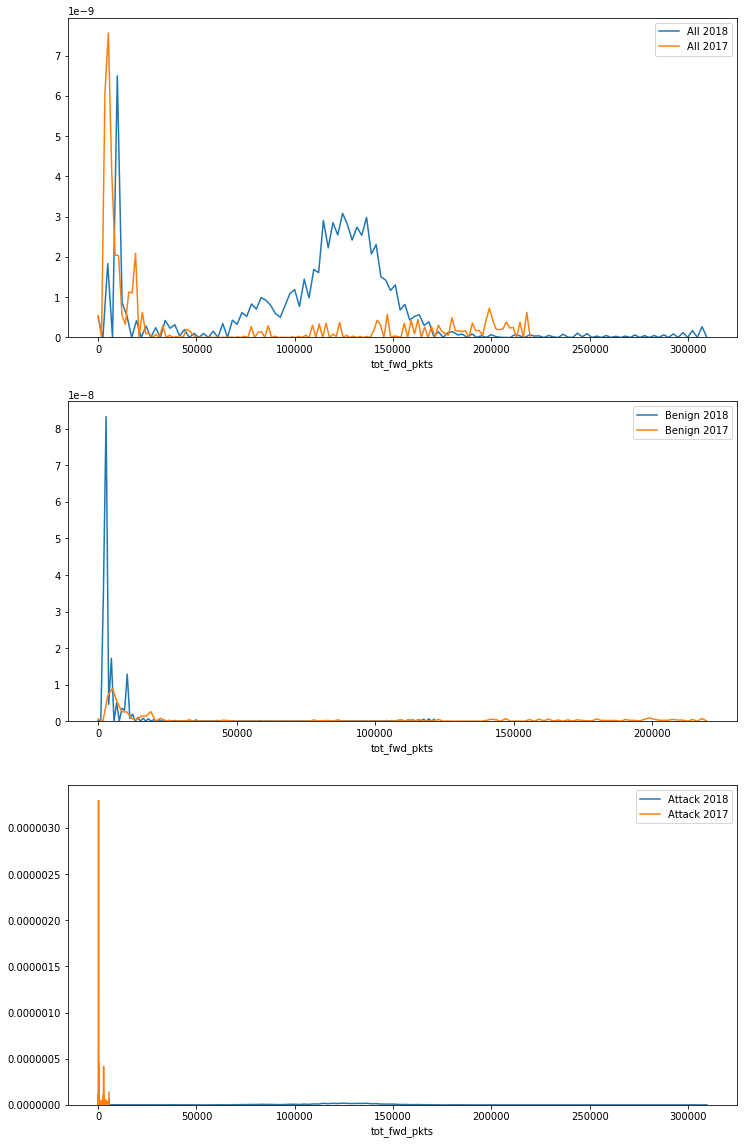

K2 All:
Ks_2sampResult(statistic=0.08538442029661275, pvalue=0.0)
K2 Benign:
Ks_2sampResult(statistic=0.1638849062280222, pvalue=0.0)
K2 Attack:
Ks_2sampResult(statistic=0.3708222970259676, pvalue=0.0)

              All 2018      All 2017   Benign 2018   Benign 2017  \
                     0             0             0             0   
nobs      1.623294e+07  2.830743e+06  1.348471e+07  2.273097e+06   
min       1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
max       3.096290e+05  2.197590e+05  1.213090e+05  2.197590e+05   
mean      2.353319e+01  9.361160e+00  6.051862e+00  1.065417e+01   
median    2.000000e+00  2.000000e+00  2.000000e+00  2.000000e+00   
std       1.521137e+03  7.496727e+02  7.640556e+01  8.365354e+02   
variance  2.313857e+06  5.620093e+05  5.837811e+03  6.997918e+05   
skewness  8.855637e+01  2.443804e+02  4.677944e+02  2.190286e+02   
kurtosis  8.271322e+03  6.175432e+04  5.486641e+05  4.960005e+04   

           Attack 2018    Attack 2017  
        

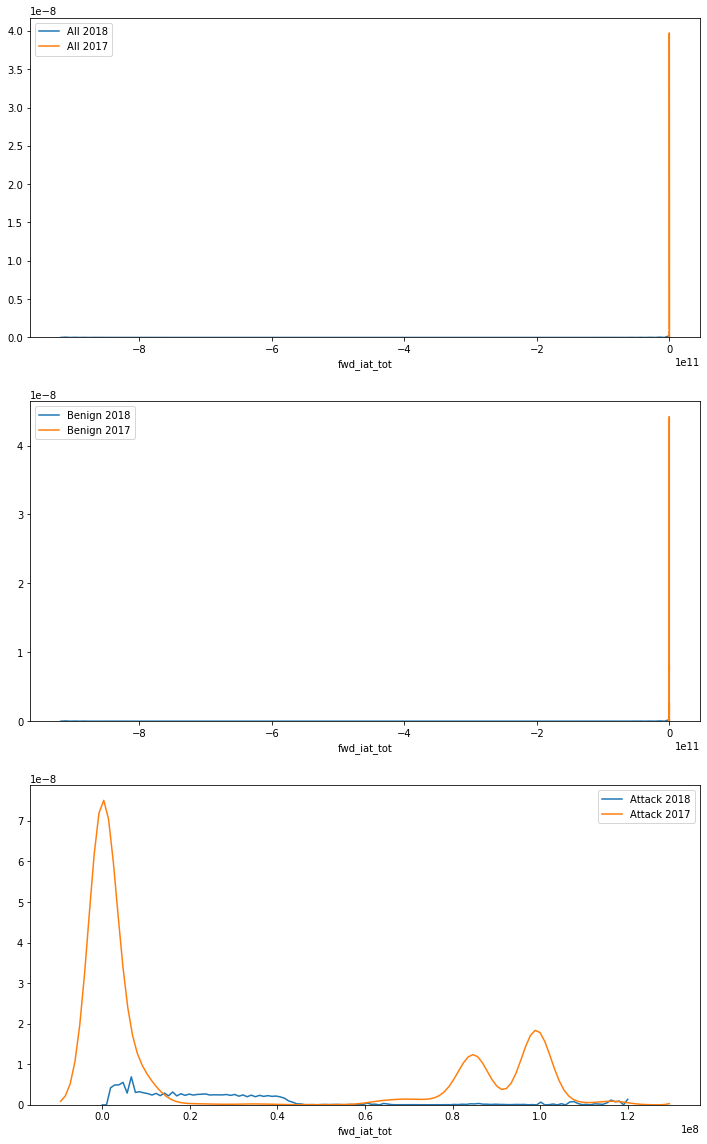

K2 All:
Ks_2sampResult(statistic=0.24261434033321583, pvalue=0.0)
K2 Benign:
Ks_2sampResult(statistic=0.2600580236392939, pvalue=0.0)
K2 Attack:
Ks_2sampResult(statistic=0.29382240416452743, pvalue=0.0)

              All 2018      All 2017   Benign 2018   Benign 2017  \
                     0             0             0             0   
nobs      1.623294e+07  2.830743e+06  1.348471e+07  2.273097e+06   
min      -9.190110e+11  0.000000e+00 -9.190110e+11  0.000000e+00   
max       1.200000e+08  1.200000e+08  1.200000e+08  1.200000e+08   
mean      1.152313e+07  1.448296e+07  1.314415e+07  1.089969e+07   
median    5.140000e+03  4.300000e+01  1.766500e+04  4.000000e+00   
std       4.940071e+08  3.357581e+07  5.419665e+08  2.999284e+07   
variance  2.440431e+17  1.127335e+15  2.937277e+17  8.995711e+14   
skewness -1.434865e+03  2.176929e+00 -1.308134e+03  2.814193e+00   
kurtosis  2.172232e+06  3.107538e+00  1.805130e+06  6.495182e+00   

           Attack 2018   Attack 2017  
        

In [48]:
for f in features_to_analyze:
    print_distributions(X, y, X_novel, y_novel, f, '2018', '2017')

The plots and the Kolmogorov-Smirnov statistics suggest that all features come from a different distribution in both datasets which poses a problem for our estimator as the estimator assumes that train, test and real-worl data stems from the same distribution.

### 5.5. Statistical tests

To rule out that the estimator uses features that are only relevant for the training dataset and not relevant for the novel dataset the next step performs the [Kolmogorov-Smirnov statistic](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html) on all the features of the datasets.

In [ ]:
from scipy.stats import ks_2samp

def ks2(x1, x2, f):
    return ks_2samp(x1[f], x2[f]).pvalue


df = load_dataset(csv_files, types)
X_2018 = df.drop(columns=['label', 'label_cat', 'label_is_attack', 'timestamp'])
y_2018 = df[['label_is_attack', 'label_cat', 'label']]

df_2017 = load_dataset(novel_files, types)
X_2017 = df_2017.drop(columns=['label', 'label_cat', 'label_is_attack', 'timestamp'])
y_2017 = df_2017[['label_is_attack', 'label_cat', 'label']]

X_2018_attack = X_2018[(y.label_is_attack == 1)]
X_2018_benign = X_2018[(y.label_is_attack == 0)]

X_2017_attack = X_2017[(y_2017.label_is_attack == 1)]
X_2017_benign = X_2017[(y_2017.label_is_attack == 0)]

k2_results = []

for c in X_2018.columns:   
    print(f"Processing {c}...")
    r = pd.DataFrame.from_dict(data = { 
        'all': ks2(X_2018, X_2017, c),
        'attack': ks2(X_2018_benign, X_2017_benign, c),
        'benign': ks2(X_2018_attack, X_2017_attack, c)
    }, orient='index', columns=[c])
    k2_results.append(r)
    
k2_values = pd.concat(k2_results, axis=1)

In [58]:
k2 = k2_values.drop(columns=features_no_variance).T
k2[(k2['all'] > 0.005) | (k2['attack'] > 0.005) | (k2['benign'] > 0.005)]

,all,attack,benign
fwd_urg_flags,1.0,1.0,0.999988
cwe_flag_count,1.0,1.0,0.999988


After removing the feature with no variance there are only 2 features left that stem from the same distribution in both dataset `fwd_urg_flags`, `cwe_flag_count` both not being good predictors.  
This shows that data from different network environment is distributed differently.

## 6. Model from combined data

In order to create a estimator that generalizes well on data from different network environments an estimator is created by using the combined [CIC-IDS-2017](https://www.unb.ca/cic/datasets/ids-2017.html) and [CIC-IDS-2018](https://www.unb.ca/cic/datasets/ids-2018.html) datasets.

### 6.1. Load combined data

In [6]:
combined_files = glob.glob(os.path.join(dataset_base_path, '*.csv')) + glob.glob(os.path.join(novel_base_path, '*.csv'))

df = load_dataset(combined_files, types, cols=selected_features + ['label'])
X = df.drop(columns=['label', 'label_cat', 'label_is_attack'])
y = df[['label_is_attack', 'label_cat', 'label']]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y.label_cat)

### 6.2. Synthetic Oversampling

Both datasets contain attack classes with a low amount of occurrences. In order to get a better detection rate for these attacks `Synthetic Minority Oversampling` is used to push the occurrences of those classes to `100000`.

In [8]:
y_train.label.value_counts()

Benign                      12606243
DoS attacks-Hulk              554388
DDOS attack-HOIC              548809
DDoS attacks-LOIC-HTTP        460953
Bot                           230526
FTP-BruteForce                161038
SSH-Bruteforce                154789
Infilteration                 129576
PortScan                      127144
DoS attacks-SlowHTTPTest      116311
DDOS LOIT                     102422
DoS attacks-GoldenEye          41441
DoS attacks-Slowloris          13429
Brute Force -Web                1694
DDOS attack-LOIC-UDP            1384
Brute Force -XSS                 706
SQL Injection                     86
Heartbleed                         9
Name: label, dtype: int64

In [9]:
cnts = y_train.label_cat.value_counts()
sample_dict = {}

for i in np.unique(y_train.label_cat):
    sample_dict[i] = max(cnts[i], 100000)

In [11]:
sm = SMOTENC(sampling_strategy=sample_dict, categorical_features=[0], n_jobs=24)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train.label_cat)

In [12]:
print('Class occurrences:')
Counter(y_train_s)

Class occurrences:


Counter({12: 161038,
         0: 12606243,
         5: 548809,
         9: 554388,
         7: 460953,
         17: 154789,
         11: 100000,
         1: 230526,
         10: 116311,
         4: 102422,
         8: 100000,
         14: 129576,
         15: 127144,
         6: 100000,
         2: 100000,
         3: 100000,
         16: 100000,
         13: 100000})

In [13]:
y_train_s = (y_train_s != 0).astype('int')
print('Binary label occurrences:')
Counter(y_train_s)

Binary label occurrences:


Counter({1: 3285956, 0: 12606243})

### 6.3. Training

For the combined estimator a gradient boosting model is trained using grid-search to find the best set of hyperparameters.

In [16]:
def train_catboost_grid(train_pool, y_train):
    minority_class_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    print(f"Minority class weight: {minority_class_weight}")
    
    param_grid = {
        'iterations': [500, 1000, 1500],
        'learning_rate': [0.3, 0.03, 0.003],
        'depth': [3, 6, 9],
        'l2_leaf_reg': [3, 6]
    }

    cls = CatBoostClassifier(loss_function='Logloss',
                             eval_metric='Recall',
                             class_weights=[1, minority_class_weight],
                             task_type='GPU',
                             verbose=True)

    cb_results = cls.grid_search(param_grid, train_pool)

    print('\nOptimal Parameters:')
    print(cb_results['params'])
    return cls

In [17]:
train_pool = Pool(X_train_s, y_train_s, cat_features=[0])
test_pool = Pool(X_test.values, cat_features=[0])

In [18]:
comb_estimator = train_catboost_grid(train_pool, y_train_s)

Minority class weight: 3.8364004265425344
0:	loss: 0.9676589	best: 0.9676589 (0)	total: 2m 14s	remaining: 1h 58m 55s
1:	loss: 0.9634058	best: 0.9676589 (0)	total: 4m 18s	remaining: 1h 52m 4s
2:	loss: 0.9516361	best: 0.9676589 (0)	total: 6m 25s	remaining: 1h 49m 16s
3:	loss: 0.9674853	best: 0.9676589 (0)	total: 8m 29s	remaining: 1h 46m 7s
4:	loss: 0.9636844	best: 0.9676589 (0)	total: 10m 33s	remaining: 1h 43m 30s
5:	loss: 0.9516361	best: 0.9676589 (0)	total: 12m 41s	remaining: 1h 41m 28s
6:	loss: 0.9687036	best: 0.9687036 (6)	total: 16m 39s	remaining: 1h 51m 53s
7:	loss: 0.9658026	best: 0.9687036 (6)	total: 20m 39s	remaining: 1h 58m 47s
8:	loss: 0.9516102	best: 0.9687036 (6)	total: 24m 41s	remaining: 2h 3m 28s
9:	loss: 0.9685558	best: 0.9687036 (6)	total: 28m 40s	remaining: 2h 6m 9s
10:	loss: 0.9656976	best: 0.9687036 (6)	total: 32m 40s	remaining: 2h 7m 43s
11:	loss: 0.9516361	best: 0.9687036 (6)	total: 36m 42s	remaining: 2h 8m 29s
12:	loss: 0.9689914	best: 0.9689914 (12)	total: 42m 32s

Conducting grid-search the following parameters were determined for an optimal estimator:

|Parameter|Value|
|---------|-----|
|Depth|9|
|L2 Leaf Regularization|3|
|Iterations|1000|
|Learning Rate|0.3|

Classification Report (Train):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99  12606243
           1       0.98      0.97      0.97   3285956

    accuracy                           0.99  15892199
   macro avg       0.99      0.98      0.98  15892199
weighted avg       0.99      0.99      0.99  15892199

Avg Precision Score: 0.955579742683623


Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   3151562
           1       0.97      0.96      0.97    661176

    accuracy                           0.99   3812738
   macro avg       0.98      0.98      0.98   3812738
weighted avg       0.99      0.99      0.99   3812738

Avg Precision Score: 0.9425657531936107


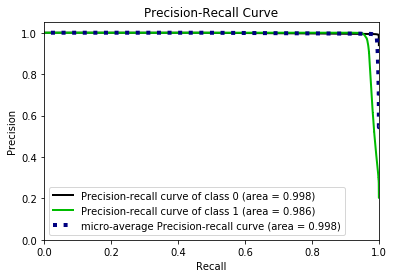

In [21]:
print_report('Train', comb_estimator, train_pool, y_train_s, comb_estimator.predict(train_pool))
print_report('Test', comb_estimator, test_pool, y_test.label_is_attack, comb_estimator.predict(test_pool), plot_pr=True)

The combined estimator shows promising performance on the test dataset with a high recall of `0.99`, precision of `0.99` and an attack detection rate (recall class 1) of `0.96`.

In [22]:
comb_estimator.save_model('models/gradient_boost_model')

## 7. Model analysis

The following figures show the feature importance calculated with the SHAP values and illustrate the influence of the most important predictor features.

In [23]:
shap.initjs()

In [24]:
shap_values = comb_estimator.get_feature_importance(test_pool, type='ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

### 7.1. Feature importance

The following listing shows the feature importances of the combined estimator calculated with permuation importance.

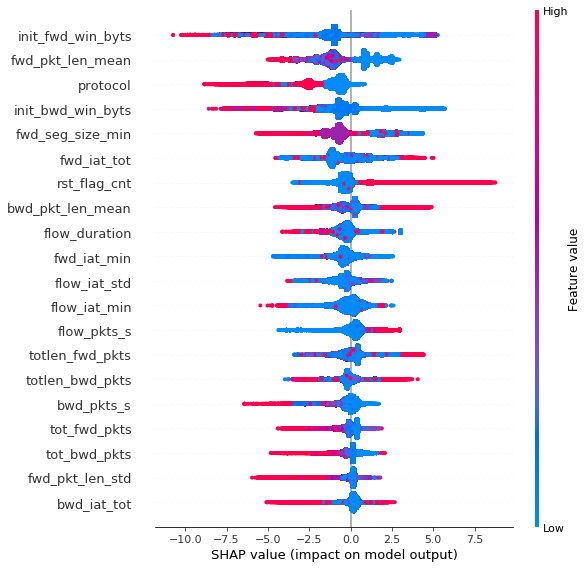

In [25]:
shap.summary_plot(shap_values, X_test)

According to SHAP analysis the following features have the highest influence on the predictions of the model:
1. `init_fwd_win_byts`: Number of bytes sent in initial window in the forward direction
2. `fwd_pkt_len_mean`: Mean size of packet in forward direction
3. `protocol`: Protocol
4. `init_bwd_win_byts`: Number of bytes sent in initial window in the backward direction
5. `fwd_seg_size_min`: Minimum segment size observed in the forward direction

### 7.2 Force Plot

In [26]:
idx = np.random.choice(np.arange(len(X_test)), 1000, replace=False)
shap.force_plot(expected_value, shap_values[idx], X_test.iloc[idx, :])

### 7.3 Depedence Plots

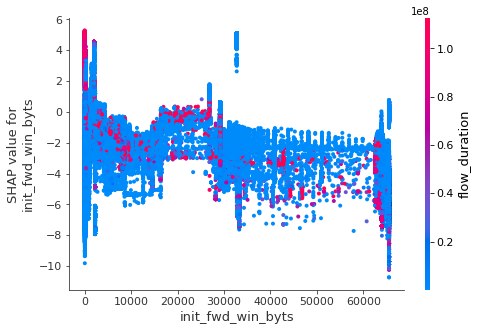

In [27]:
shap.dependence_plot('init_fwd_win_byts', shap_values, X_test)

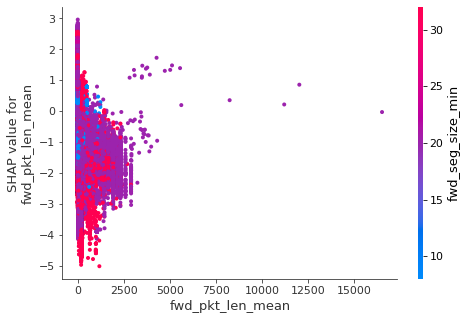

In [28]:
shap.dependence_plot('fwd_pkt_len_mean', shap_values, X_test)

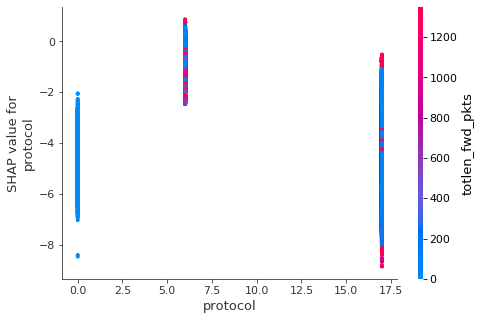

In [29]:
shap.dependence_plot('protocol', shap_values, X_test)

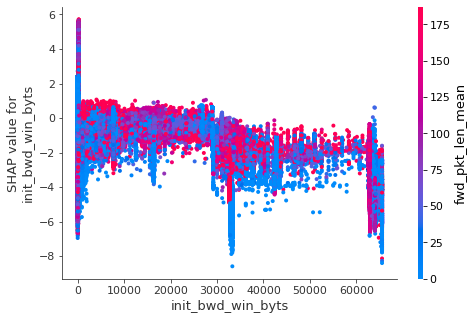

In [30]:
shap.dependence_plot('init_bwd_win_byts', shap_values, X_test)

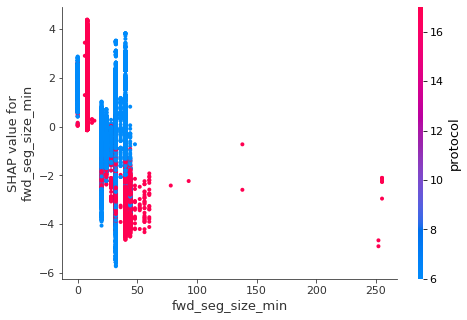

In [31]:
shap.dependence_plot('fwd_seg_size_min', shap_values, X_test)

## 8. Conclusion

Even though the performance of the combined estimator is compelling it can be assumed that the estimator will not generalize well to different network environments because of the observed differences in distributions. The statistical features recorded in the single datasets seem to be highly dependent on the network topology and the configurations of host and client machines in the network. [Machine Learning for Networking](https://arxiv.org/ftp/arxiv/papers/1709/1709.08339.pdf) discusses the difficulties imposed to machine learning systems by the heterogeneity of different network environments.

In order to cope with this problem the following suggestions are proposed:
* an estimator has to be trained with more varied data originating from different network environments,
* an estimator has to be trained with data originating from the network environment it will be deployed in.

The second option seems more promising as it is very difficult to obtain real-world network attack datasets of high quality.  
The fact that data has to be collected in the target environment can be alleviated by only collecting benign network traffic and using an anomaly detection approach to detect network attacks. This option will be pursued in further work using neural networks.